# Learn to use graphs with piecewise-constant pulses

**Understand Boulder Opal graphs and nodes by smoothing a piecewise-constant pulse**

In this tutorial, you will develop a practical intuition on how graphs and their components are used in Boulder Opal by defining, smoothing, and plotting a piecewise-constant function.

If you want to learn more about how and why Boulder Opal uses graphs, you can read our [Understanding graphs in Boulder Opal](https://docs.q-ctrl.com/boulder-opal/topics/understanding-graphs-in-boulder-opal) topic.

## Filtering a piecewise-constant signal

Your task will be to smooth out a piecewise-constant signal, using a Boulder Opal graph and adding the relevant nodes.

A piecewise-constant (PWC) function takes discrete values $\{\Omega_n\}$ at $N$ different segments:
$$
\Omega_\mathrm{pwc}(t) = \Omega_n \quad \mathrm{for} \ t \in \left[ \frac{(n-1)T}{N}, \frac{nT}{N} \right)  .
$$

A simple way to smooth functions is to convolve them with a [smoothing kernel](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/Graph/gaussian_convolution_kernel), $K(t)$.
$$
\Omega_\mathrm{smooth}(t)
= \Omega_\mathrm{pwc}(t) \ast K(t)
= \int_{-\infty}^\infty   \Omega_\mathrm{pwc}(\tau) K(t-\tau) \mathrm{d}\tau
$$ 

You will build a graph that creates a piecewise-constant signal and smooths it out.
Along the way, you will use different types of graph nodes and operations, which is key to extracting the full potential of graph computations in Boulder Opal.

### Import libraries and start a Boulder Opal session

You always begin by importing the required libraries.
To learn more about installing Boulder Opal, please refer to the [Get started](https://docs.q-ctrl.com/boulder-opal/get-started) guide.

In [1]:
# Import packages.
import numpy as np
from pprint import pprint
import qctrlvisualizer
import boulderopal as bo

### Create an empty graph

Instantiate an empty Boulder Opal graph object.

In [2]:
graph = bo.Graph()

You can now start adding nodes to the graph to define your desired computation.

### Add nodes to graph

#### Add a Tensor node with the pulse values in Hz

Start by defining a NumPy array with the values of your piecewise-constant pulse in MHz.
Then use the `graph.multiply` method of the graph object to add a node representing the multiplication of each value with `1e6` to turn their unit to Hz.

In [3]:
pulse_values_in_mhz = 2 * np.pi * np.array([0, 2, -3, 3, 2, 4, -1, 0])  # MHz
pulse_values_in_hz = graph.multiply(pulse_values_in_mhz, 1e6)

You add nodes to the graph's structure by calling methods on the `graph` object, in order to define the target computation.
Note that the computation hasn't been executed at this point yet.
Therefore, if you now print `pulse_values_in_hz`, you don't get the value of the graph node in question.

In [4]:
print(pulse_values_in_hz)

<Tensor: name="multiply_#0", operation_name="multiply", shape=(8,)>


Instead, you get a description of the Tensor node you've added to the graph.
In particular, you can see its shape, which is that of a 1D tensor with 8 elements, as expected.
You can also see the name of the called operation which created the node (in this case, `graph.multiply`).

Finally, you can see that the Tensor has also been automatically assigned a name (`"multiply_#0"`), which can be used to extract the node value after executing the graph.
You can change the node's name by accessing its `name` attribute.

In [5]:
pulse_values_in_hz.name = "signal values"
print(pulse_values_in_hz)

<Tensor: name="signal values", operation_name="multiply", shape=(8,)>


#### Add a Pwc node with the piecewise-constant signal

Use `graph.pwc_signal` to add a [`Pwc`](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/Pwc) node representing the original signal (which you will filter later) by passing the values of its eight piecewise-constant segments and its total duration of `1e-6 seconds`.

Give it a name so you can retrieve it easily when evaluating the graph.
You can do that by passing a string to the `name` parameter of the graph operation.

In [6]:
signal_duration = 1e-6  # seconds

original_signal = graph.pwc_signal(
    values=pulse_values_in_hz, duration=signal_duration, name="original signal"
)
print(original_signal)

<Pwc: name="original signal", operation_name="pwc_signal", value_shape=(), batch_shape=()>


Again you see a description of the node, in this case of type `Pwc`, with the name you assigned to it and the operation that created it.

You can also see that it has a `value_shape`.
As it is a scalar function (a signal) it has a `value_shape` of `()`.

<!-- Something about the `batch_shape` ... it represents something overly complex to explain here, you could learn more about it, if only we had written a topic about it... -->

Being a `Pwc`, `original_signal` has `durations` and `values` attributes, which you can access.
Print them to find out what they are.

In [7]:
print("durations:", original_signal.durations)
print("values:", original_signal.values)

durations: [1.25e-07 1.25e-07 1.25e-07 1.25e-07 1.25e-07 1.25e-07 1.25e-07 1.25e-07]
values: <Tensor: name="getattr_#2", operation_name="getattr", shape=(8,)>


The `durations` attribute is a NumPy array containing the duration of each piecewise-constant segment of the function.
In this case, it has a value of `1.25e-7` in each of its eight segments, which add up to a total duration of `1 µs`.
The `values` attribute is a Tensor with the values of the Pwc at each segment, so in this case it is a 1D Tensor of shape `(8,)`.

### Evaluate the graph constructed so far

You can check whether the graph you have built so far is working as expected by evaluating it.

In the previous steps, you assigned a name to each node you wanted to retrieve individually when executing the graph.
Now you pass a list with the names of all the nodes of interest to the `output_node_names` parameter of the `boulderopal.execute_graph` function.

In [8]:
result = bo.execute_graph(
    graph=graph, output_node_names=["signal values", "original signal"]
)

Your task (action_id="1828682") is queued.
Your task (action_id="1828682") has started.
Your task (action_id="1828682") has completed.


### Extract results

Now that the graph has been evaluated, the values of the requested nodes can be accessed through the `result["output"]` dictionary.

List all available result components, which should coincide with the `output_node_names` you passed to `boulderopal.execute_graph`.

In [9]:
print(f"Node results available: {list(result['output'].keys())}")

Node results available: ['signal values', 'original signal']


The output of Tensor nodes is a dictionary with a `"value"` key.

In [10]:
print(result["output"]["signal values"])

{'value': array([        0.        ,  12566370.61435917, -18849555.92153876,
        18849555.92153876,  12566370.61435917,  25132741.22871834,
        -6283185.30717959,         0.        ])}


The output of a Pwc node is a dictionary containing arrays representing the `"values"` and `"durations"` of the PWC function

In [11]:
# Using the pprint package for an easy-to-read output.
print("PWC durations:", result["output"]["original signal"]["durations"])
print("PWC values:", result["output"]["original signal"]["values"])

PWC durations: [1.25e-07 1.25e-07 1.25e-07 1.25e-07 1.25e-07 1.25e-07 1.25e-07 1.25e-07]
PWC values: [        0.          12566370.61435917 -18849555.92153876
  18849555.92153876  12566370.61435917  25132741.22871834
  -6283185.30717959         0.        ]


### Plot results

You can pass the result of the executed node named `original signal` to the Q-CTRL Visualizer's [`qctrlvisualizer.plot_controls`](https://docs.q-ctrl.com/references/qctrl-visualizer/qctrlvisualizer/plot_controls) function to visualize it.
Note that you can also configure other parameters in the plotting.

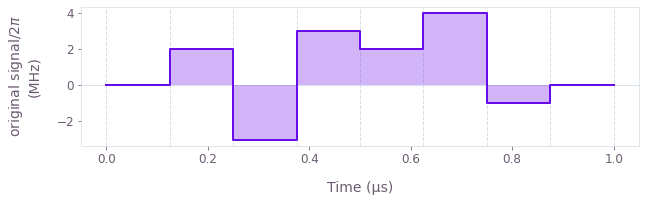

In [12]:
qctrlvisualizer.plot_controls({"original signal": result["output"]["original signal"]})

### Add more nodes to graph

#### Create a linear filter

Now that you have a piecewise-constant signal, the next step before smoothing it is to define the smoothing kernel.

Add a node to the graph representing the filter kernel using `graph.gaussian_convolution_kernel` with a standard deviation of $3 \times 10^{-8}$ seconds.

In [13]:
convolution_kernel = graph.gaussian_convolution_kernel(std=3e-8)
print(convolution_kernel)

<ConvolutionKernel: operation_name="gaussian_convolution_kernel">


Note that nodes of type [`ConvolutionKernel`](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/ConvolutionKernel) don't have a `name` attribute, so you can't extract their value from the graph after evaluating it.

#### Convolve the PWC function with the filter

Filter the piecewise-constant signal by convolving it with the kernel using the `graph.convolve_pwc` operation.

In [14]:
filtered_signal = graph.convolve_pwc(pwc=original_signal, kernel=convolution_kernel)
print(filtered_signal)

<Stf: operation_name="convolve_pwc", value_shape=(), batch_shape=()>


You can see that the output is an [`Stf`](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/Stf) node, which represents sampleable functions (usually smooth ones).
It has the same `value_shape` and `batch_shape` as the original `Pwc` signal.

`Stf` nodes don't have a `name` attribute either, and therefore can't be extracted from the graph.
Instead, you can discretize them with the `graph.discretize_stf` operation (using the same total duration, `1e-6`) to create a sampled `Pwc`, which can then be retrieved from the graph.
Make sure you use a large enough `segment_count` for the discretization, so that the piecewise-constant representation is smooth.

In [15]:
discretized_signal = graph.discretize_stf(
    stf=filtered_signal, duration=1e-6, segment_count=500, name="filtered signal"
)
print(discretized_signal)

<Pwc: name="filtered signal", operation_name="discretize_stf", value_shape=(), batch_shape=()>


This new `Pwc` node you have added to the graph represents the final smooth filtered signal which you will extract after evaluating the graph.

### Evaluate graph

Now you are ready to execute the whole graph you constructed.

Since you have already inspected the output of some intermediate nodes, extract only the final filtered signal.

In [16]:
result = bo.execute_graph(graph=graph, output_node_names="filtered signal")

Your task (action_id="1828689") is queued.
Your task (action_id="1828689") has started.
Your task (action_id="1828689") has completed.


### Plot results

You can plot the final filtered signal using [`qctrlvisualizer.plot_controls`](https://docs.q-ctrl.com/references/qctrl-visualizer/qctrlvisualizer/plot_controls) with its `smooth` parameter set to `True`.

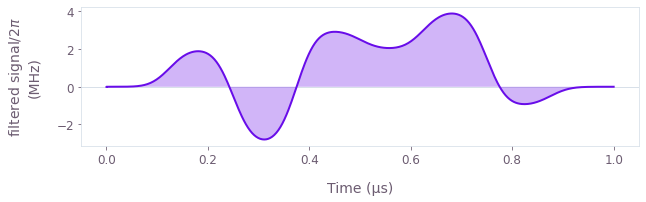

In [17]:
qctrlvisualizer.plot_controls(result["output"], smooth=True)

**Congratulations!** You have worked your way through the fundamentals of Boulder Opal graphs, and can now put your skills to use by solving relevant problems proposed in our several [user guides](https://docs.q-ctrl.com/boulder-opal/user-guides).

You can refer to our topic [Understanding graphs in Boulder Opal](https://docs.q-ctrl.com/boulder-opal/topics/understanding-graphs-in-boulder-opal) for further context on what graphs are and why we use them.